<a href="https://colab.research.google.com/github/Iasonaspg/ser-repo/blob/main/ser3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!ls  # Check if required cuda 9.0 amd64-deb file is downloaded
!dpkg -i cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!ls /var/cuda-repo-9-0-local | grep .pub
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update
!sudo apt-get install cuda-9.0

In [ ]:
!pip install thundersvm

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/My Drive/Acted Emotional Speech Dynamic Database.zip (Unzipped Files)/Acted Emotional Speech Dynamic Database/')
!ls 

 anger						      feature_train_vector.csv
 cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb   happiness
 disgust					      sadness
 fear						     'Tools and Documentation'
 feature_test_vector.csv


In [3]:
import numpy as np
import scipy
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio, display

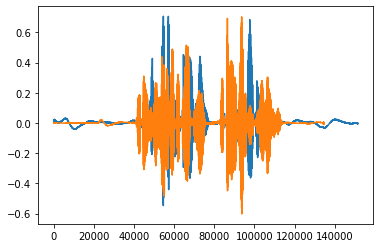

In [4]:
# load audio file
from pathlib import Path
fs = 22050
n_fft, hop = 1024, 256

def get_train_wav_dir(dir_name,fs=44100):
  return [ librosa.load(p,fs)[0] for p in Path().glob('./' + dir_name + '/train' + '/*.wav') ]

def get_test_wav_dir(dir_name,fs=44100):
  return [ librosa.load(p,fs)[0] for p in Path().glob('./' + dir_name + '/test' + '/*.wav') ]



emotions = ["sadness","happiness","anger","fear","disgust"]

# list of len(emotions) that contains lists of numpy arrays. Each numpy array belongs to a single wav file
train_wav = []
test_wav = []
for emotion in emotions:
  train_wav.append(get_train_wav_dir(emotion,fs))
  test_wav.append(get_test_wav_dir(emotion,fs))


display(Audio(train_wav[1][0], rate=fs))
plt.plot(train_wav[0][0])
plt.plot(train_wav[1][0])
plt.show()

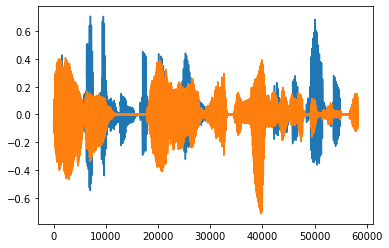

In [6]:
for i in range(len(train_wav)):
  for j in range(len(train_wav[i])):
    train_wav[i][j], _ = librosa.effects.trim(train_wav[i][j],top_db=15,frame_length=128,hop_length=32)
    #display(Audio(i, rate=fs))
    #plt.plot(i)
    #plt.show()
    #plt.plot(i_t)
    #plt.show()

for i in range(len(test_wav)):
  for j in range(len(test_wav[i])):
    test_wav[i][j], _ = librosa.effects.trim(test_wav[i][j],top_db=15,frame_length=128,hop_length=32)

# print(index)
plt.plot(train_wav[0][0])
plt.plot(train_wav[2][7])

In [55]:
display(Audio(train_wav[0][0], rate=fs))
print(train_wav[1][0].shape)

(66368,)


In [70]:
from librosa.feature import spectral

# Gets a list of wav signals and returns a numpy array of features x nFrames_total and a list of len(input) containing the nFrames per signal
def extract_features(wav,label):
  spectral_centroid = spectral.spectral_centroid(wav[0], sr=fs, n_fft=n_fft, hop_length=hop)
  spectral_rolloff = spectral.spectral_rolloff(wav[0], sr=fs, hop_length=hop,roll_percent=0.30)
  zero_crossing_rate = spectral.zero_crossing_rate(wav[0], frame_length=n_fft, hop_length=hop)
  mfcc = librosa.feature.mfcc(wav[0], sr=fs, n_fft=n_fft, hop_length=hop, n_mfcc=7)
  desired_mfcc = np.concatenate((mfcc[1:2,:],mfcc[4:5,:],mfcc[6:7,:]),axis=0)
  mfcc_delta = librosa.feature.delta(desired_mfcc, order=1, mode='nearest')
  mfcc_delta2 = librosa.feature.delta(desired_mfcc, order=2, mode='nearest')
  feature_vector = np.concatenate((spectral_centroid,spectral_rolloff,zero_crossing_rate,desired_mfcc,mfcc_delta,mfcc_delta2),axis=0)
  nFrames = [0 for i in range(len(wav))]
  nFrames[0] = spectral_centroid.shape[1]
  for i in range(1,len(wav)):
    spectral_centroid = spectral.spectral_centroid(wav[i], sr=fs, n_fft=n_fft, hop_length=hop)
    spectral_rolloff = spectral.spectral_rolloff(wav[i], sr=fs, hop_length=hop,roll_percent=0.30)
    zero_crossing_rate = spectral.zero_crossing_rate(wav[i], frame_length=n_fft, hop_length=hop)
    mfcc = librosa.feature.mfcc(wav[i], sr=fs, n_fft=n_fft, hop_length=hop, n_mfcc=7)
    desired_mfcc = np.concatenate((mfcc[1:2,:],mfcc[4:5,:],mfcc[6:7,:]),axis=0)
    mfcc_delta = librosa.feature.delta(desired_mfcc, order=1, mode='nearest')
    mfcc_delta2 = librosa.feature.delta(desired_mfcc, order=2, mode='nearest')
    feature_vector1 = np.concatenate((spectral_centroid,spectral_rolloff,zero_crossing_rate,desired_mfcc,mfcc_delta,mfcc_delta2),axis=0)
    feature_vector = np.concatenate((feature_vector,feature_vector1),axis=1)
    nFrames[i] = spectral_centroid.shape[1]
  label_vec = [label for i in range(feature_vector.shape[1])]
  #print(feature_vector.shape[1])
  feature_vector = np.concatenate((feature_vector,np.array([label_vec])),axis=0)
  return feature_vector, nFrames

test_nframes = []
train_nframes = []
feature_train_vector, _ = extract_features(train_wav[0],0)
feature_test_vector, test_nframe = extract_features(test_wav[0],0)
test_nframes.append(test_nframe)
for i in range(1,len(train_wav)):
  train_feat_vec, train_nframe = extract_features(train_wav[i],i)
  train_nframes.append(train_nframe)
  feature_train_vector = np.concatenate((feature_train_vector,train_feat_vec),axis=1)
  test_feat_vec, test_nframe = extract_features(test_wav[i],i)
  test_nframes.append(test_nframe)
  feature_test_vector = np.concatenate((feature_test_vector,test_feat_vec),axis=1)
  print(len(train_wav[i]))
  print(train_wav[i][60].shape)


print(feature_test_vector.shape)
#print(happy_train_feat_vec.shape)
print('=')
print(feature_train_vector.shape)
#print(feature_vector[:,0:2])

102
(64480,)
103
(45280,)
103
(60224,)
104
(98528,)
(13, 24961)
=
(13, 146764)


In [ ]:
a = np.asarray(feature_train_vector)
np.savetxt("feature_train_vector.csv", a, delimiter=",")

a = np.asarray(feature_test_vector)
np.savetxt("feature_test_vector.csv", a, delimiter=",")

In [58]:
import sklearn
normalizer = sklearn.preprocessing.Normalizer().fit(feature_train_vector[0:12,:].T)

feature_train_norm = normalizer.transform(feature_train_vector[0:12,:].T) 
feature_test_norm = normalizer.transform(feature_test_vector[0:12,:].T)
print(feature_train_vector.shape,feature_train_norm.shape)

(13, 146891) (146891, 12)


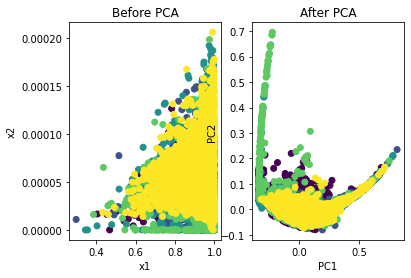

In [59]:
#from sklearn import decomposition
pca = sklearn.decomposition.PCA(n_components=12)
pca_train = pca.fit_transform(feature_train_norm[:,0:12])

fig, axes = plt.subplots(1,2)
axes[0].scatter(feature_train_norm[:,0], feature_train_norm[:,2], c=feature_train_vector[12,].T)
axes[0].set_xlabel('x1')
axes[0].set_ylabel('x2')
axes[0].set_title('Before PCA')
axes[1].scatter(pca_train[:,0], pca_train[:,2], c=feature_train_vector[12,].T)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('After PCA')
plt.show()



In [60]:
print(pca.explained_variance_ratio_,"\n")
#print(pca.explained_variance_)
print(abs( pca.components_ )[0],"\n")
print(abs( pca.components_ )[1],"\n")
print(abs( pca.components_ )[2],"\n")


[8.72692381e-01 9.84257817e-02 1.50294684e-02 7.75749334e-03
 4.65666938e-03 8.67535386e-04 2.20132192e-04 1.90581192e-04
 9.26743602e-05 4.15993898e-05 2.56763311e-05 7.39072287e-09] 

[3.86273287e-01 9.18104183e-01 5.37970022e-05 8.49970914e-02
 2.52906630e-02 3.22490797e-03 4.56962669e-04 9.48372975e-05
 1.61075830e-04 1.46349927e-03 8.46424909e-04 1.68262828e-04] 

[6.46570109e-02 6.58118362e-02 7.11842387e-05 9.94688274e-01
 3.51328664e-02 2.00169060e-02 6.09671270e-03 1.11069758e-03
 2.30897262e-03 2.00984896e-02 8.74050714e-04 2.48593033e-04] 

[6.05325391e-01 2.40786650e-01 3.91876199e-05 5.32364108e-02
 7.15362627e-01 2.45010761e-01 1.09664468e-02 4.42617494e-03
 1.86967106e-03 2.23805364e-02 1.85930129e-02 2.22332905e-03] 



In [ ]:
from sklearn import svm
from thundersvm import SVC
import time
#X = np.concatenate((feature_vector[:,0:50000],happy_feat_vec[:,0:50000]),axis=1)
#y = np.concatenate((np.zeros((50000)),np.ones((50000))),axis=0)

#print(X.shape)
#print(y.shape)
clf = svm.SVC()
str = time.time()
clf.fit(feature_train_vector[0:12,:].T, feature_train_vector[12,:].T)
print(time.time()-str)
#print(feature_vector[:,3:5])
#clf.predict(feature_vector[:,200:240].T)
#clf_gpu = SVC()
#str = time.time()
#clf_gpu.fit(feature_train_vector[0:12,:].T, feature_train_vector[12,:].T)
#print(time.time()-str)

2382.715900182724
1085.5837166309357


In [ ]:
import statistics 
from statistics import mode 

def get_label(y):
  return mode(y)



In [1]:
from sklearn.metrics import accuracy_score

print("CPU: \n")

accuracy_list = []

for k in test_nframes:
  i = 0
  for j in k:
    pred = clf.predict(feature_test_vector[0:12,i:i+j].T)
    acc = accuracy_score(feature_test_vector[12,i:i+j].T,pred,True)
    accuracy_list.append(acc)
    print(acc)
    i = i + j

print("Mean CPU accuracy: ", np.mean(accuracy_list))

#print("GPU: \n")
#
#for k in test_nframes:
#  i = 0
#  for j in k:
#    pred = clf_gpu.predict(feature_test_vector[0:12,i:i+j].T)
#    print(accuracy_score(feature_test_vector[12,i:i+j].T,pred,True))
#    i = i + j

pred = clf.predict(feature_test_vector[0:12,:].T)
print(accuracy_score(feature_test_vector[12,:].T,pred,True))


CPU: 



NameError: ignored

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf_lgr = LogisticRegression(C=100,random_state=0,solver='liblinear',max_iter=600)
clf_lgr.fit(feature_train_vector[0:12,:].T, feature_train_vector[12,:].T)
clf_lgr.predict(feature_test_vector[0:12,:].T)
print(clf_lgr.score(feature_train_vector[0:12,:].T, feature_train_vector[12,:].T))

pred = clf_lgr.predict(feature_test_vector[0:12,:].T)
print(accuracy_score(feature_test_vector[12,:].T,pred,True))

0.33148456024638195
0.331917791755138


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf_lgr = LogisticRegression(C=100,random_state=0,solver='liblinear',max_iter=600)
clf_lgr.fit(feature_train_norm, feature_train_vector[12,:].T)
clf_lgr.predict(feature_test_norm)
print(clf_lgr.score(feature_train_norm[:,0:12], feature_train_vector[12,:].T))

pred = clf_lgr.predict(feature_test_norm[:,0:12])
print(accuracy_score(feature_test_vector[12,].T,pred,True))

In [75]:
print("CPU: \n")

accuracy_list = []

for k in test_nframes:
  i = 0
  for j in k:
    pred = clf_lgr.predict(feature_test_vector[0:12,i:i+j].T)
    acc = accuracy_score(feature_test_vector[12,i:i+j].T,pred,True)
    #acc = clf_lgr.score(feature_test_vector[0:12,i:i+j].T,feature_test_vector[12,i:i+j])
    accuracy_list.append(acc)
    #print(acc)
    i = i + j
  
print("Mean CPU accuracy: ", np.mean(accuracy_list))

CPU: 

Mean CPU accuracy:  0.6179780101382256


In [76]:
print("CPU: \n")

accuracy_list = []

for k in train_nframes:
  i = 0
  for j in k:
    pred = clf_lgr.predict(feature_train_vector[0:12,i:i+j].T)
    acc = accuracy_score(feature_train_vector[12,i:i+j].T,pred,True)
    #acc = clf_lgr.score(feature_test_vector[0:12,i:i+j].T,feature_test_vector[12,i:i+j])
    accuracy_list.append(acc)
    #print(acc)
    i = i + j
  
print("Mean CPU accuracy: ", np.mean(accuracy_list))

CPU: 

Mean CPU accuracy:  0.6403572724437385


In [ ]:
print("CPU: \n")

accuracy_list = []

for k in test_nframes:
  i = 0
  for j in k:
    pred = clf_lgr.predict(feature_test_norm[i:i+j,])
    acc = accuracy_score(feature_test_vector[12,i:i+j].T,pred,True)
    #acc = clf_lgr.score(feature_test_norm,feature_test_vector[12,i:i+j])
    accuracy_list.append(acc)
    #print(acc)
    i = i + j
  
print("Mean CPU accuracy: ", np.mean(accuracy_list))

CPU: 

Mean CPU accuracy:  0.5776524845968057


In [ ]:
def spectrogram(wav,n_fft=256,hop_length=128,window='hamming'):
    D = librosa.stft(wav, n_fft, hop_length, window='hamming')
    spect, _ = librosa.magphase(D, power=1)
    return spect

spec = spectrogram(wav,256)

print('Spectrogram shape', spec.shape)
print('{min %.2f} {mean %.2f} {max %.2f}' % (np.amin(spec), np.mean(spec), np.amax(spec)))
plt.plot(wav)
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(spec, origin='lower')
plt.show()

plt.hist(spec)
plt.show()

log_spec = librosa.power_to_db(spec ** 2, ref=np.min)
plt.figure(figsize=(10,10))
plt.imshow(log_spec, origin='lower',vmin=-60)
plt.show()
plt.hist(log_spec)
plt.xlabel('Magnitude (dB)')
plt.show()

In [56]:
print(n_fft)
print(hop)
x_train_sp = []
train_labels = []
k = 0
for i in train_wav:
  for j in i:
    mel_sp = librosa.feature.melspectrogram(j, sr=fs, n_fft=2048, hop_length=1024, n_mels=64, power=1.0, fmin=10., fmax=4000.)
    pad_width = 64 - mel_sp.shape[1]
    mel_sp = librosa.amplitude_to_db(mel_sp)
    if (pad_width > 0):
      mel_sp = np.pad(mel_sp, pad_width=((0, 0), (0, pad_width)), mode='constant')
    mel_sp = mel_sp[:,0:64]
    print(mel_sp.shape)
    x_train_sp.append(mel_sp)
    train_labels.append(k)
  k = k + 1

k = 0
x_test_sp = []
test_labels = []
for i in test_wav:
  for j in i:
    mel_sp = librosa.feature.melspectrogram(j, sr=fs, n_fft=2048, hop_length=512, n_mels=64, power=1.0, fmin=10., fmax=4000.)
    pad_width = 64 - mel_sp.shape[1]
    mel_sp = librosa.amplitude_to_db(mel_sp)
    if (pad_width > 0):
      mel_sp = np.pad(mel_sp, pad_width=((0, 0), (0, pad_width)), mode='constant')
    mel_sp = mel_sp[:,0:64]
    x_test_sp.append(mel_sp)
    test_labels.append(k)
  k = k + 1


x_train = np.asarray(x_train_sp)
x_test = np.asarray(x_test_sp)

#display(Audio(train_wav[0][0],fs))
#display(Audio(x_train_sp[0][0],fs))
print(x_train.shape)

1024
256
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(

In [25]:
mel_sp_npar.shape[1:]

(804, 804)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_22 (Flatten)         (None, 4096)              0         
_________________________________________________________________
dense_43 (Dense)             (None, 2053)              8411141   
_________________________________________________________________
dense_44 (Dense)             (None, 2053)              4216862   
_________________________________________________________________
dense_45 (Dense)             (None, 5)                 10270     
Total params: 12,638,273
Trainable params: 12,638,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
6/6 - 0s - loss: 671.1204 - accuracy: 0.2327 - val_loss: 1211.6531 - val_accuracy: 0.0000e+00
Epoch 2/30
6/6 - 0s - loss: 149.2153 - accuracy: 0.3241 - val_loss: 279.6701 - val_accuracy: 0.3290
Epoch 3/30
6/6 - 0s - loss: 36.116

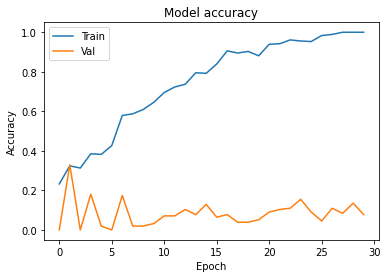

3/3 [==============================] - 0s 3ms/step - loss: 11.0038 - accuracy: 0.3409
Evaluation accuray 0.34090909361839294 loss: 11.003780364990234


In [66]:
import sklearn.preprocessing
import tensorflow as tf
import keras
from keras.layers import *



# define model
n_frames = x_train.shape[1]
n_features = x_train.shape[2]
num_classes = 5


mlp = keras.Sequential() 
mlp.add(Flatten(input_shape=x_train.shape[1:]))
mlp.add(Dense(num_classes+(n_frames*n_features)//2, activation='relu'))
mlp.add(Dense(num_classes+(n_frames*n_features)//2, activation='relu'))
mlp.add(Dense(num_classes, activation='softmax'))

mlp.summary()

# model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
mlp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = mlp.fit(x=x_train, y=keras.utils.to_categorical(train_labels), batch_size=64, epochs=30, verbose=2, validation_split=0.3)

# Plot training & validation accuracy values
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

loss, acc = mlp.evaluate(x_test, keras.utils.to_categorical(test_labels))
print('Evaluation accuray', acc,'loss:', loss)